<a href="https://colab.research.google.com/github/ErlantzCalvo/Parkinson_Detection/blob/erlantz/Parkinson_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive 
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
%cd drive/My\ Drive
%cd 'Colab Notebooks/'
%cd 'datasets/ParkinsonDisease/'

/content/drive/My Drive
/content/drive/My Drive/Colab Notebooks
/content/drive/My Drive/Colab Notebooks/datasets/ParkinsonDisease


In [55]:
!pip install tpot

     |████████████████████████████████| 92kB 2.5MB/s 
     |████████████████████████████████| 163kB 10.6MB/s 
  Created wheel for stopit: filename=stopit-1.1.2-cp36-none-any.whl size=11956 sha256=b037332c448003853ed405f771db45ea3b4493ee0397276db386f7196e13dfac
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built stopit


In [70]:
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from tpot import TPOTClassifier
from sklearn.ensemble import RandomForestClassifier

# Data explanation
The data .csv has the next format: \\
  X ; Y; Z; Pressure; GripAngle; Timestamp; Test ID

----------------
Test ID: \\
0: Static Spiral Test ( Draw on the given spiral pattern) \\
1: Dynamic Spiral Test ( Spiral pattern will blink in a certain time, so subjects need to continue on their draw) \\
2: Circular Motion Test (Subjectd draw circles around the red point)

# Sources and explanation
Isenkul, Muhammed & Sakar, Betul & Kursun, O.. (2014). Improved Spiral Test Using Digitized Graphics Tablet for Monitoring Parkinson’s Disease. 10.13140/RG.2.1.1898.6005. 

Sakar, Betul & Isenkul, Muhammed & Sakar, C. Okan & Sertbaş, Ahmet & Gurgen, F. & Delil, Sakir & Apaydin, Hulya & Kursun, Olcay. (2013). Collection and Analysis of a Parkinson Speech Dataset With Multiple Types of Sound Recordings. Biomedical and Health Informatics, IEEE Journal of. 17. 828-834. 10.1109/JBHI.2013.2245674. 

# Dataset
https://archive.ics.uci.edu/ml/datasets/Parkinson+Disease+Spiral+Drawings+Using+Digitized+Graphics+Tablet


# Loading data
We've got 2 different datasets:
  

*   **Control**: People who did the tests without having the Parkinson disease. 
*   **Parkinson**: People who did the tests having the Parkinson disease. 

*Note:* The parkinson dataset is splitted in two different paths, so we'll load both of them and then mix them.

In [47]:
CONTROL_DATASET_PATH = 'hw_dataset/control'
PARKINSON_DATASET_PATH = 'hw_dataset/parkinson'
PARKINSON_DATASET_PATH_2 = 'new_dataset/parkinson'


def loadDatasets(control_path, parkinson_path):
  COLUMN_NAMES = ['X', 'Y', 'Z', 'Pressure', 'GripAngle', 'Timestamp', 'Test ID','UserId']
  userid = 0
  #Load Control dataset
  control_files = os.listdir(control_path)
  df_control = pd.DataFrame(columns=COLUMN_NAMES)
  #df_control.columns = COLUMN_NAMES
  for i in tqdm(range(len(control_files)), desc= 'Control files: ', unit=' files'):
    new_user_path = os.path.join(control_path, control_files[i])
    new_user = pd.read_csv(new_user_path, header=None,  sep=';', names=COLUMN_NAMES)
    new_user['UserId'] = userid
    df_control = df_control.append(new_user)
    userid +=1


  #Load parkinson dataset
  parkinson_files = os.listdir(parkinson_path)
  df_parkinson = pd.DataFrame(columns=COLUMN_NAMES)

  for j in tqdm(range(len(parkinson_files)), desc= 'Parkinson files: ', unit=' files'):
    new_user_path = os.path.join(parkinson_path, parkinson_files[j])  
    new_user = pd.read_csv(new_user_path, header=None,  sep=';',names=COLUMN_NAMES)
    new_user['UserId'] = userid
    df_parkinson = df_parkinson.append(new_user)
    userid +=1

  parkinson_files =  os.listdir(PARKINSON_DATASET_PATH_2)
  for k in tqdm(range(len(parkinson_files)), desc= 'Parkinson files: ', unit=' files'):
    new_user_path = os.path.join(PARKINSON_DATASET_PATH_2, parkinson_files[i])  
    new_user = pd.read_csv(new_user_path, header=None,  sep=';')
    new_user['UserId'] = userid
    df_parkinson = df_parkinson.append(new_user)
    userid +=1


  #df_parkinson.columns = COLUMN_NAMES
  return df_parkinson, df_control
df_parkinson, df_control= loadDatasets(CONTROL_DATASET_PATH, PARKINSON_DATASET_PATH)


Parkinson files: 100%|██████████| 37/37 [00:01<00:00, 18.79 files/s]


# Getting variable variation
We extract how much does a certain variable change during all the dataset

In [48]:
def getSubjectDeltas(subjectData):
  subjectGripAngleDelta = 0
  subjectPressureDelta = 0
  subjectCoordDelta = 0

  for i in range(len(subjectData)-1):
    subjectGripAngleDelta += abs(subjectData['GripAngle'].iloc[i+1] - subjectData['GripAngle'].iloc[i])
    
    subjectPressureDelta += abs(subjectData['Pressure'].iloc[i+1] - subjectData['Pressure'].iloc[i])
    subjectPressureDelta += abs(subjectData['Z'].iloc[i+1] - subjectData['Z'].iloc[i])

    subjectCoordDelta += abs(subjectData['X'].iloc[i+1] - subjectData['X'].iloc[i]) + abs(subjectData['Y'].iloc[i+1] - subjectData['Y'].iloc[i])

  return subjectGripAngleDelta, subjectPressureDelta, subjectCoordDelta


We prepare the final dataset with the model will be trained and tested. So we will do some feature extraction and join the control dataset and the parkinson dataset.





In [49]:
def extractFeatures(dataset, subjects, isParkinson):
  NEW_COLUMNS = ['UserID', 'CoordinatesDelta','GripAngleVariance', 'GripAngleStd', 'GripAngleDelta', 'PressureVariance', 'PressureStd', 'PressureDelta', 'Duration', 'Test ID', 'Parkinson']
  df_polished = pd.DataFrame(columns=NEW_COLUMNS)

  for i in range(3):
    for j in tqdm(range(len(subjects)), desc=f'Test {j}: '):
      df_subject = dataset[(dataset['Test ID'] ==i) & (dataset['UserId']==subjects[j])]
      
      if len(df_subject)>0:
        #insert new values to the dataset
        angleVariance = df_subject['GripAngle'].var()
        angleStDeviation = df_subject['GripAngle'].std()

        pressureVariance =  df_subject['Pressure'].var()
        pressureStDeviation = df_subject['Pressure'].std()

        startTime = df_subject['Timestamp'].iloc[0]
        endTime = df_subject['Timestamp'].iloc[-1]
        duration = endTime - startTime

        gripAngleDelta, pressureDelta, coordDelta = getSubjectDeltas(df_subject)
        gripAngleDelta = gripAngleDelta / duration
        pressureeDelta = pressureDelta / duration
        coordDelta = coordDelta / duration

        df_polished = df_polished.append({'UserID': int(subjects[j]), 'CoordinatesDelta' : coordDelta, 'GripAngleVariance' : angleVariance, 'GripAngleStd' : angleStDeviation, 'GripAngleDelta' : gripAngleDelta, 'PressureVariance' : pressureVariance, 'PressureStd' : pressureStDeviation, 'PressureDelta' : pressureDelta, 'Duration' : duration, 'Test ID' : i, 'Parkinson' : isParkinson},ignore_index = True)
        df_polished[['UserID', 'Duration', 'Test ID', 'Parkinson']] =  df_polished[['UserID', 'Duration', 'Test ID', 'Parkinson']].astype(int)
  return df_polished

def prepareDataset(controlDataset, parkinsonDataset):
  control_usersId = controlDataset['UserId'].unique()
  control_polished = extractFeatures(controlDataset, control_usersId, 0)

  parkinson_usersId = parkinsonDataset['UserId'].unique()
  parkinson_polished = extractFeatures(parkinsonDataset, parkinson_usersId, 1)

  frames = [control_polished, parkinson_polished]
  final_dataset = pd.concat(frames)
  
  return final_dataset
final_dataset = prepareDataset(df_control, df_parkinson)
final_dataset

Subject: 100%|██████████| 62/62 [00:04<00:00, 12.60it/s]


,UserID,CoordinatesDelta,GripAngleVariance,GripAngleStd,GripAngleDelta,PressureVariance,PressureStd,PressureDelta,Duration,Test ID,Parkinson
0,0,0.139108,23503.860477,153.309688,1.625958,5512.006177,74.242886,10457.0,18137,0,0
1,1,0.121589,20211.096496,142.165736,1.115038,3224.260485,56.782572,11295.0,21219,0,0
2,2,0.050859,23453.945369,153.146810,0.764640,3321.122674,57.629182,21226.0,48428,0,0
3,3,0.100648,16846.073495,129.792425,0.959993,1787.981835,42.284534,12835.0,24521,0,0
4,4,0.063277,22162.988710,148.872391,0.646752,4067.676182,63.778336,13262.0,39335,0,0
...,...,...,...,...,...,...,...,...,...,...,...
68,35,0.035420,4711.990537,68.643940,1.130587,36321.531088,190.582085,20620.0,38396,2,1
69,36,0.010228,258.257857,16.070403,0.169978,21991.916184,148.296717,8490.0,13590,2,1
70,37,0.075708,9071.367686,95.243728,1.347038,0.000000,0.000000,6222.0,11967,2,1
71,38,0.019841,2236.877389,47.295638,1.254485,0.000000,0.000000,5970.0,14213,2,1


# Data visualization

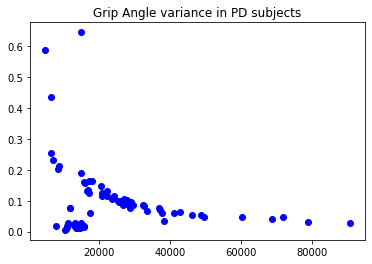

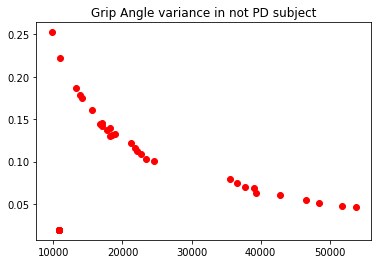

In [50]:
control_data = final_dataset[final_dataset['Parkinson']==0]
control_grip = control_data['CoordinatesDelta']
control_time = control_data['Duration']
controlY = control_grip.to_list()
controlX = control_time.to_list()

parkinson_data = final_dataset[final_dataset['Parkinson']==1]
parkinson_grip = parkinson_data['CoordinatesDelta']
parkinson_time = parkinson_data['Duration']
parkinsonY = parkinson_grip.to_list()
parkinsonX = parkinson_time.to_list()

plt.plot( parkinsonX, parkinsonY, 'bo')
plt.title('Grip Angle variance in PD subjects')
plt.show()

plt.plot(controlX, controlY, 'ro')
plt.title('Grip Angle variance in not PD subject')
plt.show()

# Prepare the training and test datasets



In [63]:
trainX = final_dataset[0::2]
trainY = trainX['Parkinson']
trainX = trainX.drop(['UserID','Parkinson'],1)

testX = final_dataset[1::2]
testY = testX['Parkinson']
testX = testX.drop(['UserID','Parkinson'],1)

In [64]:
lr = LogisticRegression()
lr.fit(trainX, trainY)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [65]:
lr.predict(testX)
lr.score(testX, testY)

0.8

In [68]:
tpot = TPOTClassifier(generations=10, verbosity=2)
tpot.fit(trainX, trainY)


Generation 1 - Current best internal CV score: 0.8545454545454545
Generation 2 - Current best internal CV score: 0.8727272727272727
Generation 3 - Current best internal CV score: 0.890909090909091
Generation 4 - Current best internal CV score: 0.890909090909091
Generation 5 - Current best internal CV score: 0.890909090909091
Generation 6 - Current best internal CV score: 0.890909090909091
Generation 7 - Current best internal CV score: 0.890909090909091
Generation 8 - Current best internal CV score: 0.890909090909091
Generation 9 - Current best internal CV score: 0.890909090909091
Generation 10 - Current best internal CV score: 0.890909090909091
Best pipeline: GradientBoostingClassifier(GaussianNB(input_matrix), learning_rate=0.01, max_depth=3, max_features=0.35000000000000003, min_samples_leaf=4, min_samples_split=9, n_estimators=100, subsample=0.9000000000000001)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
               disable_update_check=False, early_stop=None, generations=10,
               log_file=<ipykernel.iostream.OutStream object at 0x7faee8245b00>,
               max_eval_time_mins=5, max_time_mins=None, memory=None,
               mutation_rate=0.9, n_jobs=1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=100,
               random_state=None, scoring=None, subsample=1.0, template=None,
               use_dask=False, verbosity=2, warm_start=False)

In [87]:
rf = RandomForestClassifier()
rf.fit(trainX, trainY)
rf.score(testX, testY)

0.8363636363636363